In [6]:
pip install ml_collections

     |████████████████████████████████| 88 kB 3.2 MB/s 


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

class ConvolutionalBlock(layers.Layer):

    def __init__(self, filters, kernel_size, padding, dropout_rate, activation, **kwargs):
        super(ConvolutionalBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.activation = activation

    def build(self, input_shape):
        self.w = tf.random_normal_initializer(mean=0.0, stddev=1e-4)

        if (self.bias):
            self.b = tf.constant_initializer(0.0)
        else:
            self.b = None

        self.conv_a = layers.Conv2D(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=1, 
            padding='same',
            kernel_initializer=self.w,
            use_bias=True,
            bias_initializer=self.b
        )

        self.max_pool_a = layers.MaxPool2D(pool_size=(2,2))
        self.bn_a = layers.BatchNormalization()
        self.activation_fnc = layers.Activation('relu')

    def call(self, inputs):
        x = self.conv_a(inputs)
        x = self.max_pool_a(x)
        x = self.bn_a(x)
        return self.activation_fnc(x)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'padding' : self.padding,
          'dropout_rate' : self.dropout_rate,
          'activation' : self.activation,
      })
      return config

class MLPBlock(layers.Layer):
    def __init__(self, hidden_units, dropout_rate, activation=None, **kwarks):
        super(MLPBlock, self).__init__(**kwarks)
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        if not activation:
            activation = tf.nn.gelu

        self.activation = activation

        # creating layers
        self.layers = []

        for units in self.hidden_units:
            self.layers.append(layers.Dense(units, activation=self.activation))
            self.layers.append(layers.Dropout(self.dropout_rate))

    def call(self, inputs):

        for layer in self.layers:
            inputs = layer(inputs)

        return inputs

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'hidden_units' : self.hidden_units,
          'dropout_rate' : self.dropout_rate,
          'activation' : self.activation,
          'layers' : self.layers,
      })
      return config
      
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwarks):
        super(Patches, self).__init__(**kwarks)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'patch_size' : self.patch_size
      })
      return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwarks):
        super(PatchEncoder, self).__init__(**kwarks)
        self.num_patches = num_patches
        
        # Layers
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'num_patches' : self.num_patches,
          # layers
          'projection' : self.projection,
          'position_embedding' : self.position_embedding,
      })
      return config

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, projection_dim, dropout_rate, normalization_rate, transformer_units, **kwarks):
        super(TransformerBlock, self).__init__(**kwarks)
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout_rate = dropout_rate
        self.normalization_rate = normalization_rate
        self.transformer_units = transformer_units

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate)
        self.attention_layer_a = layers.MultiHeadAttention(
            num_heads = self.num_heads,
            key_dim = self.projection_dim,
            dropout = self.dropout_rate,
        )
        self.add_a = layers.Add()

        self.ln_b = layers.LayerNormalization(epsilon=self.normalization_rate)
        self.mlp_block_b = MLPBlock(
            hidden_units=self.transformer_units, 
            dropout_rate=self.dropout_rate
        )

        self.add_b = layers.Add()

    def call(self, encoded_patches):
        x1 = self.ln_a(encoded_patches)
        attention_layer = self.attention_layer_a(x1, x1)
        # attention_layer = self.softmax_b(attention_layer)
        
        x2 = self.add_a([attention_layer, encoded_patches])
        x3 = self.ln_b(x2)
        x3 = self.mlp_block_b(x3)
        x3 = self.add_b([x3, x2])
        return x3

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'num_heads' : self.num_heads,
          'projection_dim' : self.projection_dim,
          'dropout_rate' : self.dropout_rate,
          'normalization_rate' : self.normalization_rate,
          'transformer_units' : self.transformer_units,
          # layers
          'ln_a' : self.ln_a,
          'attention_layer_a' : self.attention_layer_a,
          'add_a' : self.add_a,
          'ln_b' : self.ln_b,
          'mlp_block_b' : self.mlp_block_b,
          'add_b' : self.add_b,
      })
      return config

class DecoderBlockCup(layers.Layer):

    def __init__(self, target_shape, filters, normalization_rate, pool_size=(2, 1), kernel_size=3, activation=None, **kwarks):
        super(DecoderBlockCup, self).__init__(**kwarks)
        self.normalization_rate = normalization_rate
        self.target_shape = target_shape
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size

        if not activation:
            activation = tf.nn.relu

        self.activation = activation

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate, name="decoder_block_cup_ln_a")
        self.reshape_a = layers.Reshape(target_shape=self.target_shape, name="decoder_block_cup_reshape_1")
        # self.conv_a = layers.Conv2D(filters=self.filters, kernel_size=self.kernel_size*2, strides=1, padding='same')
        # self.max_pool_a = layers.MaxPooling2D(pool_size=self.pool_size)
        # self.bn_a = layers.BatchNormalization()
        # self.activation_fnc = layers.Activation('relu')
        # self.upsample_a = layers.UpSampling2D(
        #     size=(2,2), interpolation='bilinear'
        # )

    def call(self, encoder_output):
        x = self.ln_a(encoder_output)
        x = self.reshape_a(x)
        
        # x = self.conv_a(x)
        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # return self.activation_fnc(x)
        # x = self.conv_a(x)    
        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # x = self.activation_fnc(x)
        # x = self.upsample_a(x)
        return x

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'normalization_rate' : self.normalization_rate,
          'target_shape' : self.target_shape,
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'pool_size' : self.pool_size,
          # layers
          'ln_a' : self.ln_a,
          'reshape_a' : self.reshape_a,
      })
      return config

class DecoderUpsampleBlock(layers.Layer):
    
    def __init__(self, filters, kernel_size=3, strides=(1, 1), pool_size=(2, 1), **kwarks):
        super(DecoderUpsampleBlock, self).__init__(**kwarks)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size

        # Layers
        self.upsample_a = layers.UpSampling2D(
            size=(2,2), interpolation='bilinear'
        )

        self.conv_a = layers.Conv2D(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=self.strides, 
            padding='same'
        )

        self.conv_transpose_a = layers.Conv2DTranspose(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=self.strides, 
            padding='same',
        )
        
        # self.max_pool_a = layers.MaxPooling2D(pool_size=self.pool_size)
        self.bn_a = layers.BatchNormalization()
        self.activation_fnc = layers.Activation('relu')
        
    def call(self, decoder_input):
        # x = self.upsample_a(decoder_input)
        # x = self.upsample_a(x)

        x = self.conv_a(decoder_input)
        # x = self.conv_transpose_a(decoder_input)    
        x = self.bn_a(x)
        # x = self.conv_a(x)

        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # x = self.activation_fnc(x)
        x = self.upsample_a(x)
        x = self.activation_fnc(x)
        return x

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'strides' : self.strides,
          'pool_size' : self.pool_size,
          # layers
          'conv_a' : self.conv_a,
          'bn_a' : self.bn_a,
          'upsample_a' : self.upsample_a,
          'activation_fnc' : self.activation_fnc,
      })
      return config

class DecoderSegmentationHead(layers.Layer):

    def __init__(self, filters=1, kernel_size=3, strides=1, target_shape=(256, 256, 16), **kwarks):
        super(DecoderSegmentationHead, self).__init__(**kwarks)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.target_shape = target_shape

        # Layers
        self.reshape_a = layers.Reshape(target_shape=(self.target_shape))
        self.conv_a = layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='same',
        )
    
    def call(self, decoder_upsample_block):
        x = self.reshape_a(decoder_upsample_block)
        return self.conv_a(x)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'strides' : self.strides,
          'target_shape' : self.target_shape,
          # layers
          'conv_a' : self.conv_a,
          'reshape_a' : self.reshape_a,
      })
      return config

class DecoderDense(layers.Layer):
    def __init__(self, normalization_rate, **kwarks):
        super(DecoderDense, self).__init__(**kwarks)
        self.normalization_rate = normalization_rate

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate, name="decoder_block_cup_ln_a")
        self.flatten_a = layers.Flatten()
        self.dropout_a = layers.Dropout(0.5)
        self.reshape_a = layers.Reshape(target_shape=(256,256,1))

    def call(self, inputs):
        x = self.ln_a(inputs)
        x = self.flatten_a(x)
        x = self.dropout_a(x)
        return self.reshape_a(x)

In [32]:
from tensorflow.keras import Model, Input

def build_model(config):
    inputs = Input(shape=config.image_size)
    patches = Patches(config.transformer.patch_size, name="patches_0")(inputs)
    encoded_patches = PatchEncoder(
        num_patches=config.transformer.num_patches, 
        projection_dim=config.transformer.projection_dim,
        name='encoded_patches_0',    
    )(patches)

    # print(f"enconded patches size {encoded_patches.shape}")

    transformer_blocks = []
    for idx in range(config.transformer.layers):
        # print(f"Starting {idx} iteration")
        encoded_patches = TransformerBlock(
            num_heads=config.transformer.num_heads, 
            projection_dim=config.transformer.projection_dim, 
            dropout_rate=config.transformer.dropout_rate, 
            normalization_rate=config.transformer.normalization_rate, 
            transformer_units=config.transformer.units, 
            name="transformer_block_"+str(idx)
        )(encoded_patches)
        transformer_blocks.append(encoded_patches)
    
    filters = [3, 128, 32, 3]
    residual_block = None
    for idx in range(len(filters)):
      if not idx:
        x = DecoderBlockCup(
            target_shape=(config.image_height//8, config.image_width//8, config.transformer.projection_dim),
            filters=filters[idx],
            normalization_rate=config.transformer.normalization_rate,
            name=f'decoder_cup_{idx}'
        )(encoded_patches)
      
      else:
          x = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(x)

          if (config.residual_blocks):
            num = 0
            if (idx == 1):
              num = -3
            elif (idx == 2):
              num = int(len(transformer_blocks)/2)

            if idx == 1:
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//8, config.image_width//8, config.transformer.projection_dim),
                  filters=filters[idx],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[-3])
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)
              x = layers.Add()([x, residual_block])


            if (idx == 2):
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//8, config.image_width//8, config.transformer.projection_dim),
                  filters=filters[idx-1],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[-5])
              residual_block = DecoderUpsampleBlock(filters=filters[idx-1], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)

              x = layers.Add()([x, residual_block])
            
            if (idx == 3):
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//8, config.image_width//8, config.transformer.projection_dim),
                  filters=filters[idx-1],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[-7])
              residual_block = DecoderUpsampleBlock(filters=filters[idx-2], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx-1], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)

              x = layers.Add()([x, residual_block])

    # x = DecoderUpsampleBlock(filters=32, kernel_size=3)(x)
    # x = DecoderUpsampleBlock(filters=3, kernel_size=3)(x)

    return Model(inputs=inputs, outputs=x)

Config:  activation: softmax
batch_size: 32
data_augmentation: true
dataset_path: dataset/
image_channels: 3
image_height: 128
image_size: !!python/tuple [128, 128, 3]
image_width: 128
learning_rate: 0.01
momentum: 0.9
n_classes: 1
num_epochs: 10
residual_blocks: true
transformer:
  dropout_rate: 0.1
  layers: 8
  normalization_rate: 1.0e-06
  num_heads: 6
  num_patches: 256
  patch_size: 8
  projection_dim: 256
  units: [768, 256]
weight_decay: 0.0001



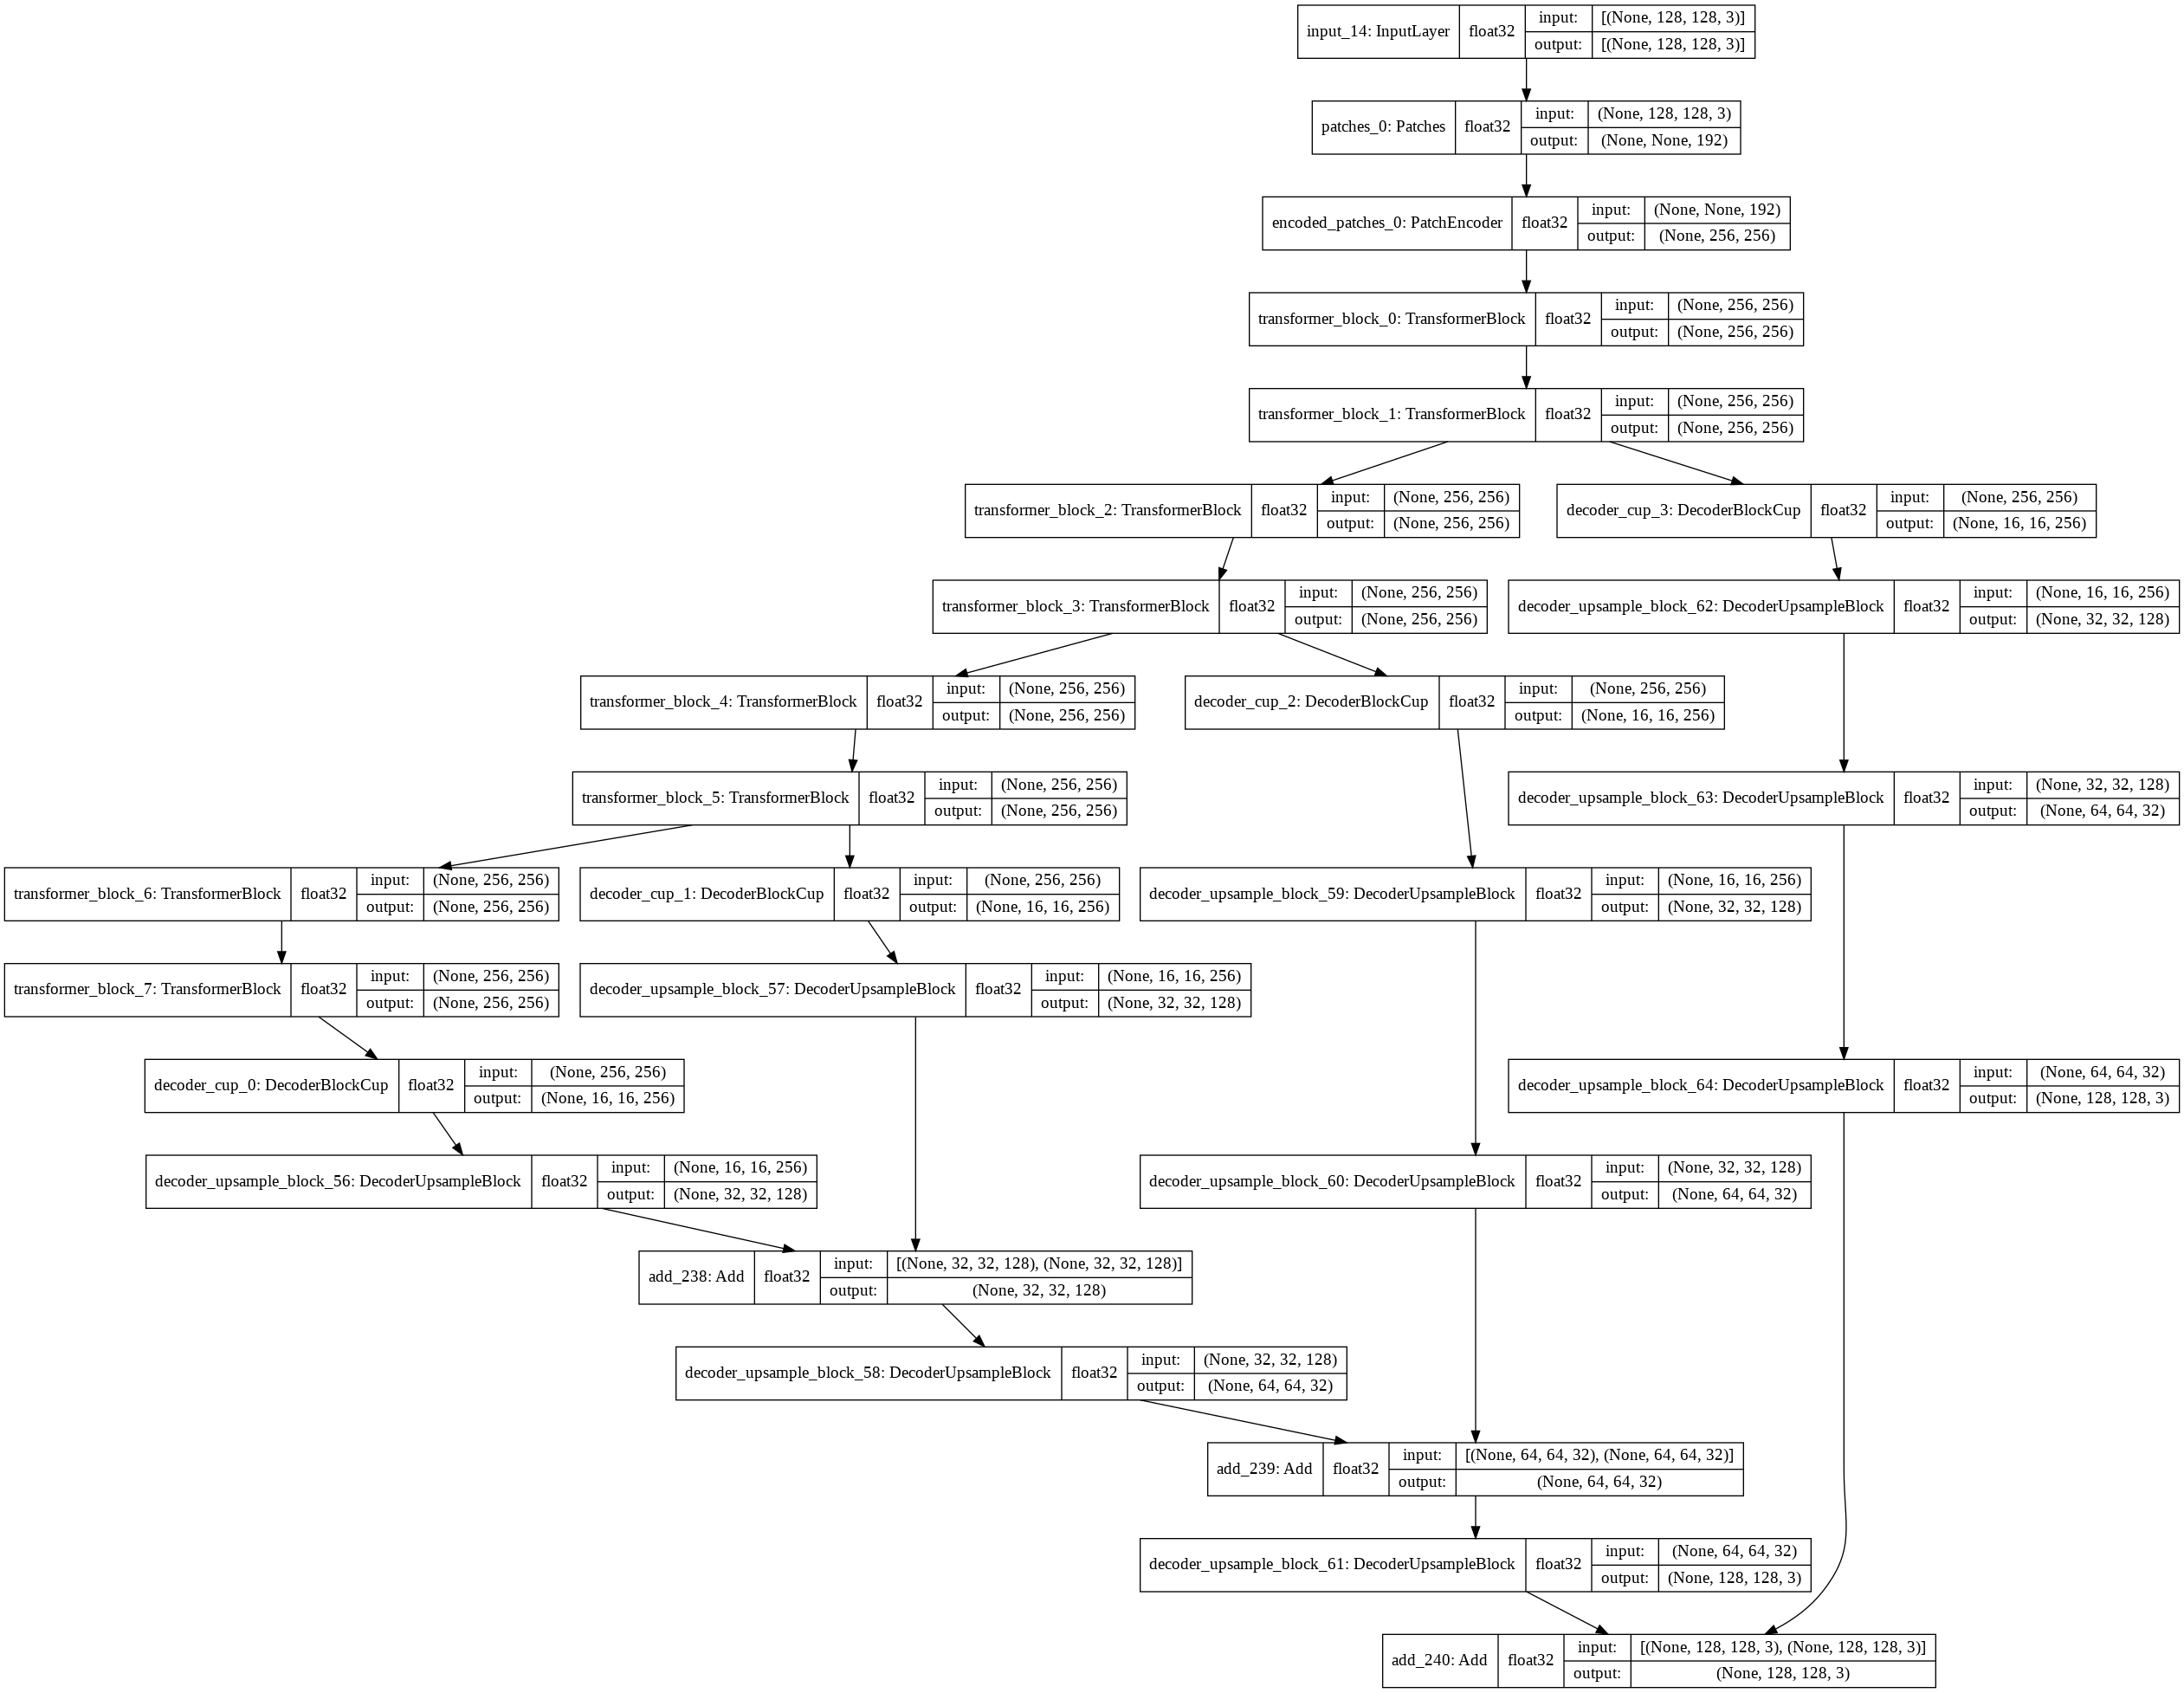

In [33]:
import ml_collections

def get_config_1():
    """
        Returns the transformer configuration 1
    """

    config = ml_collections.ConfigDict()
    config.dataset_path = 'dataset/'
    config.learning_rate = 0.01
    config.weight_decay = 1e-4
    config.momentum = 0.9
    config.batch_size = 16
    config.num_epochs = 10
    config.image_height = 128
    config.image_width = 128
    config.image_channels = 3
    config.image_size = (config.image_height, config.image_width, config.image_channels)
    config.residual_blocks = False
    config.data_augmentation = False
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.patch_size = 8
    config.transformer.num_patches = (config.image_size[0] // config.transformer.patch_size)**2
    config.transformer.projection_dim = 256
    config.transformer.units = [
        config.transformer.projection_dim * 3, # (3) 1536 --  (4) 2048
        config.transformer.projection_dim, # 512
        # config.transformer.projection_dim, # 64
    ]
    config.transformer.layers = 8
    config.transformer.num_heads = 6
    config.transformer.dropout_rate = 0.1
    config.transformer.normalization_rate = 1e-6

    config.n_classes = 1
    config.activation = 'softmax'

    return config

import tensorflow as tf

config_ml = get_config_1()
config_ml.batch_size = 32
# config_ml.transformer.layers = 5
# config_ml.transformer.num_heads = 4

# config_ml.transformer.projection_dim = 512

# config_ml.transformer.units = [
#     config_ml.transformer.projection_dim * 2, # (3) 1536 --  (4) 2048
#     config_ml.transformer.projection_dim, # 512
#     # config.transformer.projection_dim, # 64
# ]

config_ml.data_augmentation = True
config_ml.residual_blocks = True
model = build_model(config_ml)

print("Config: ", config_ml)

VIEW_TRAINIG = 'axial/'
LABEL = 'left-cerebellum-white-matter'

config = {
    'DATASET_PATH': config_ml.dataset_path,
    'VIEW_TRAINIG': VIEW_TRAINIG,
    'LABEL': LABEL,
    'IMAGE_SIZE': (config_ml.image_height, config_ml.image_width),
    'BATCH_SIZE': config_ml.batch_size,
    'DATA_AUGMENTATION': config_ml.data_augmentation,
}

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [34]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
patches_0 (Patches)             (None, None, 192)    0           input_14[0][0]                   
__________________________________________________________________________________________________
encoded_patches_0 (PatchEncoder (None, 256, 256)     114944      patches_0[0][0]                  
__________________________________________________________________________________________________
transformer_block_0 (Transforme (None, 256, 256)     1972992     encoded_patches_0[0][0]          
____________________________________________________________________________________________

In [35]:
import tensorflow as tf

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete99YZ1I/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete99YZ1I/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [36]:
from tensorflow.keras import backend as K

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

OUTPUT_CHANNELS = 3

smooth = 100

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Callbacks
	
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1,
    patience=25
)

# Model Checkpoing
model_check = ModelCheckpoint(
    'best_model.hdf5', 
    save_best_only=True,
    save_weights_only=True, 
    monitor='val_loss', 
    mode='min'
)

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', iou]
)

In [39]:
tf.keras.backend.clear_session()

EPOCHS = 150
VAL_SUBSPLITS = 10
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[early_stop, model_check]
)

Epoch 1/150
57/57 [==============================] - 107s 1s/step - loss: 0.8528 - accuracy: 0.6516 - iou: 0.5645 - val_loss: 1.8146 - val_accuracy: 0.3275 - val_iou: 0.7591
Epoch 2/150
57/57 [==============================] - 61s 1s/step - loss: 0.7207 - accuracy: 0.7187 - iou: 0.4939 - val_loss: 2.3473 - val_accuracy: 0.3785 - val_iou: 0.9718
Epoch 3/150
57/57 [==============================] - 61s 1s/step - loss: 0.6687 - accuracy: 0.7398 - iou: 0.4929 - val_loss: 0.8055 - val_accuracy: 0.6974 - val_iou: 0.8485
Epoch 4/150
57/57 [==============================] - 61s 1s/step - loss: 0.6124 - accuracy: 0.7621 - iou: 0.5135 - val_loss: 0.9685 - val_accuracy: 0.6293 - val_iou: 0.7997
Epoch 5/150
57/57 [==============================] - 61s 1s/step - loss: 0.5755 - accuracy: 0.7753 - iou: 0.5492 - val_loss: 0.6781 - val_accuracy: 0.7405 - val_iou: 0.7576
Epoch 6/150
57/57 [==============================] - 61s 1s/step - loss: 0.5530 - accuracy: 0.7835 - iou: 0.5845 - val_loss: 0.7011 - 

In [40]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

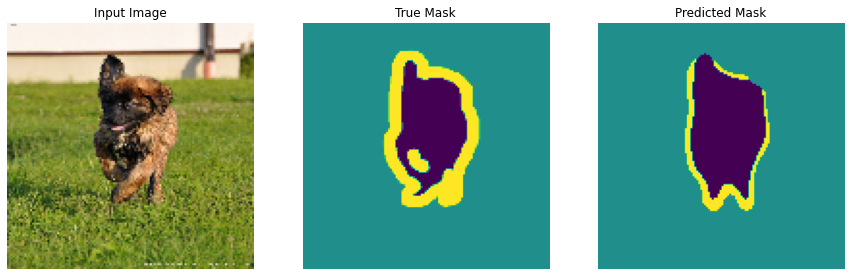

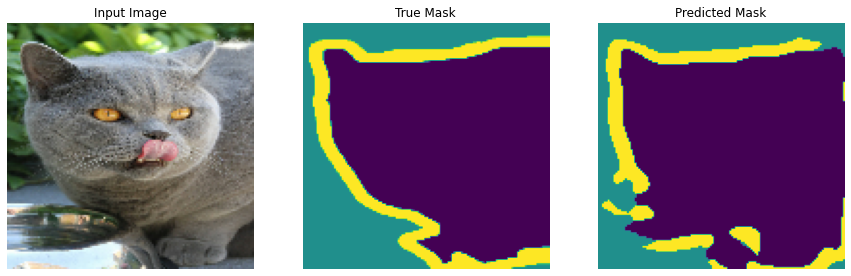

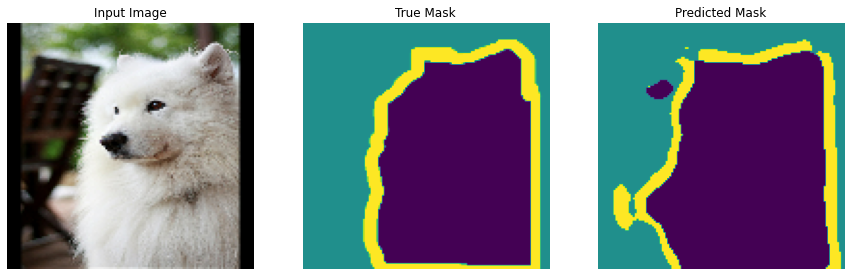

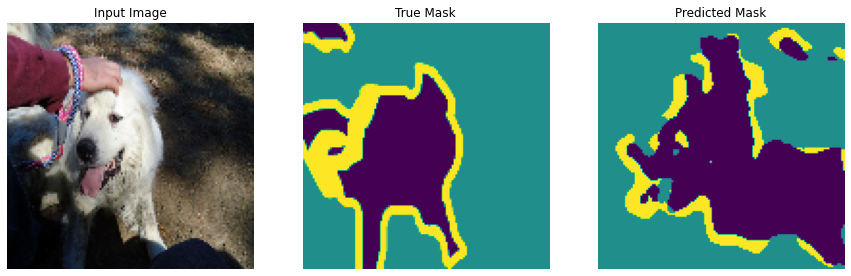

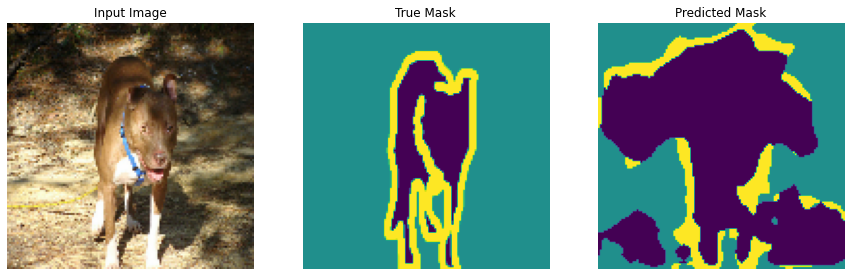

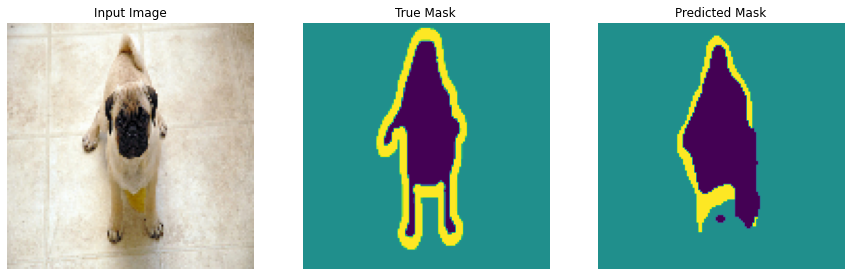

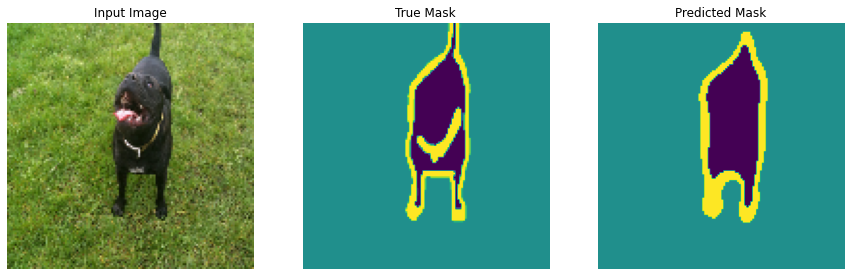

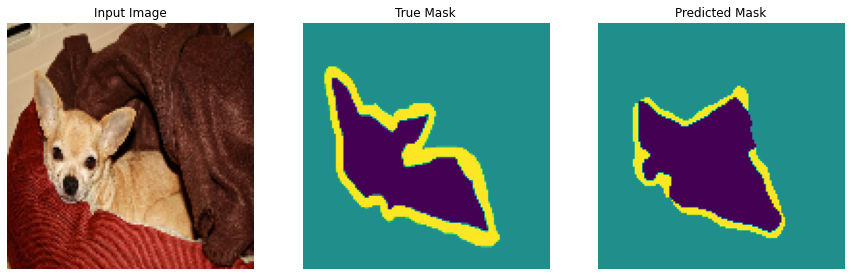

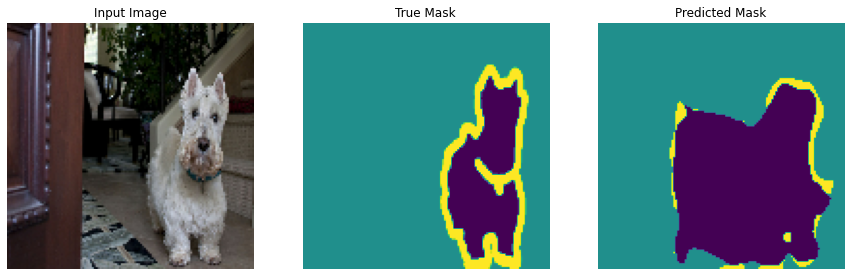

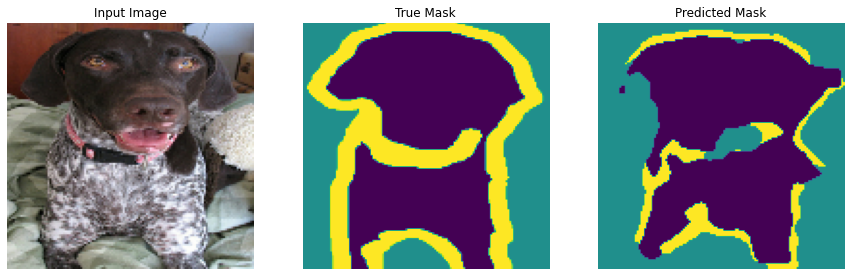

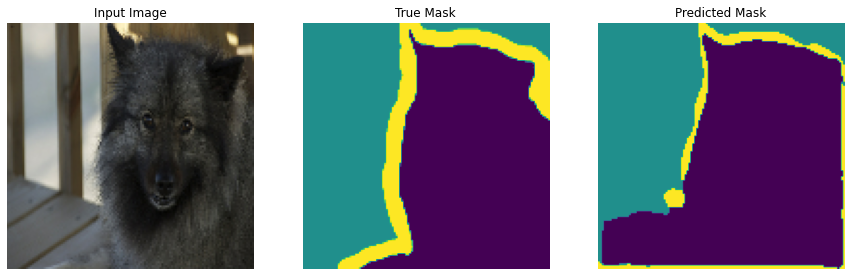

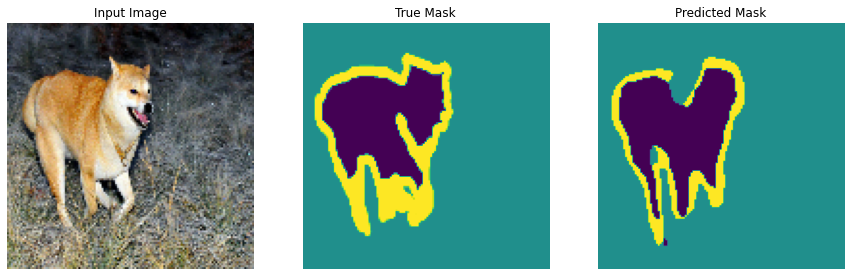

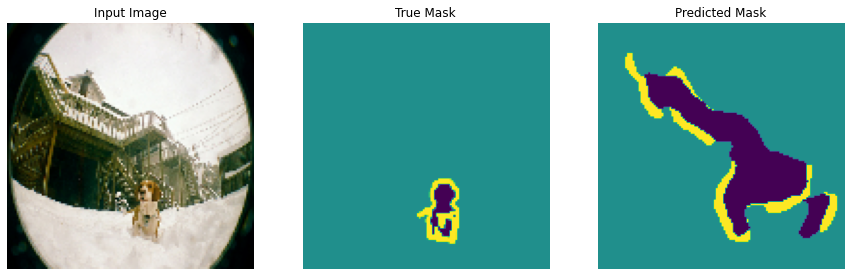

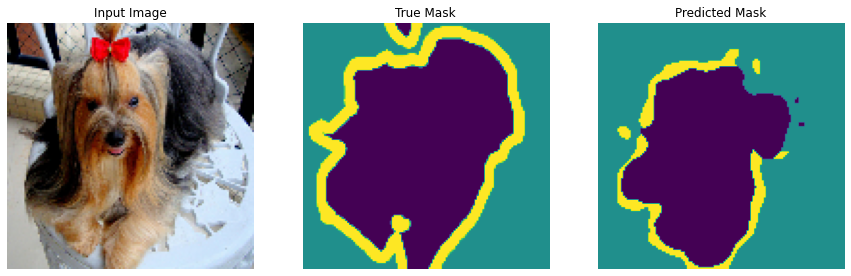

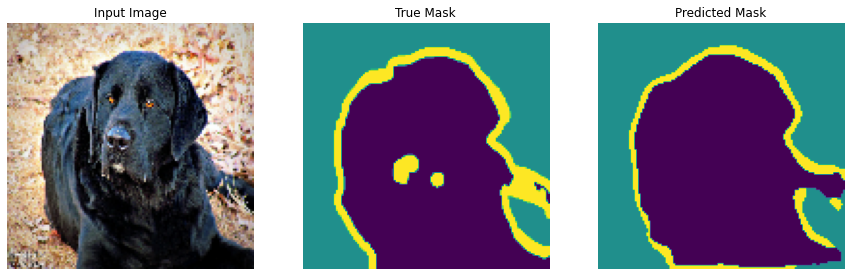

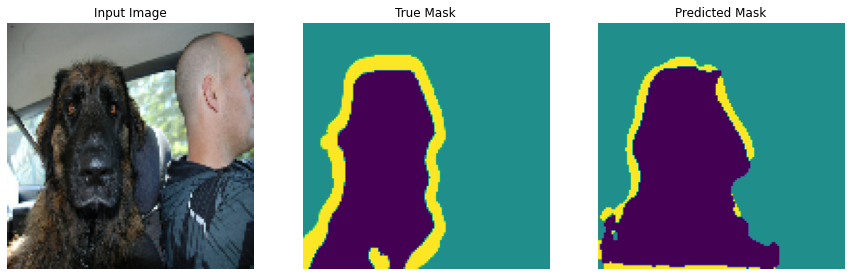

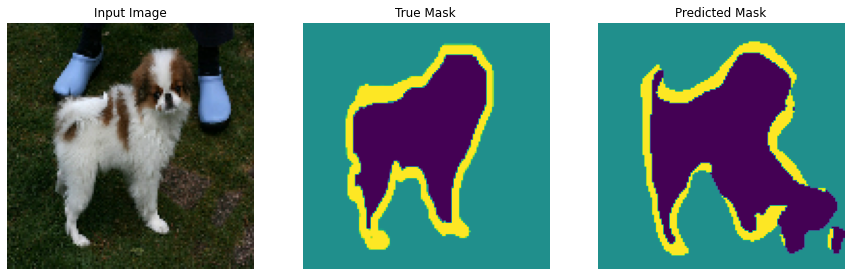

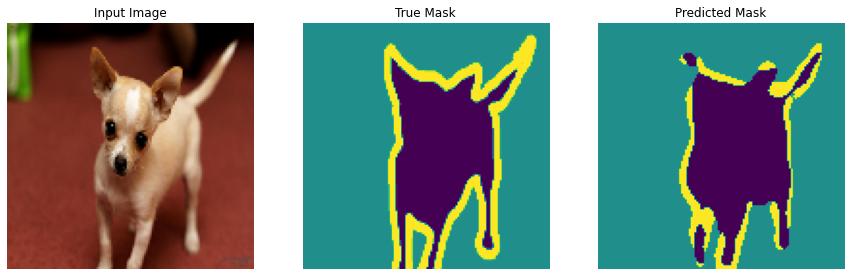

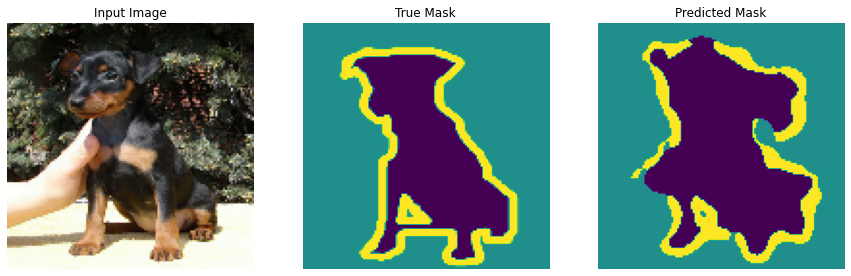

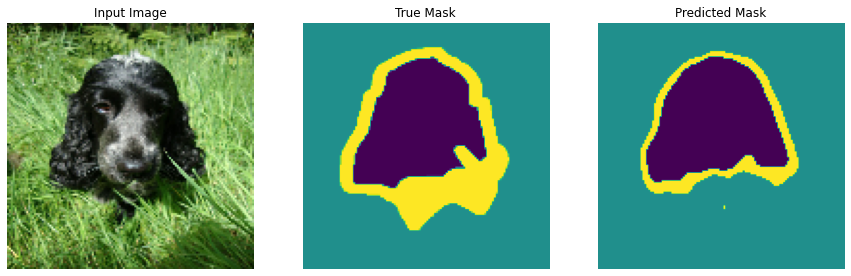

In [41]:
show_predictions(model, test_dataset, 20)

In [ ]:
model.save_weights('60+epochs+weights', save_format='tf')

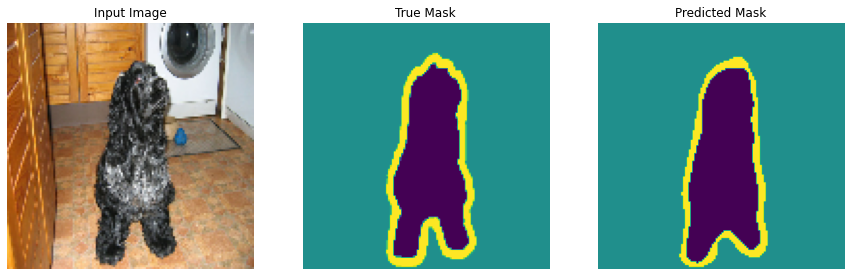

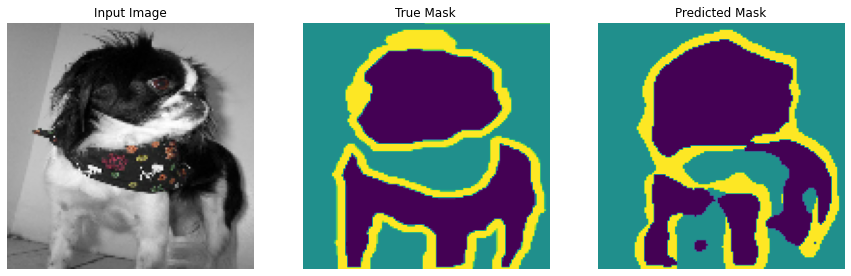

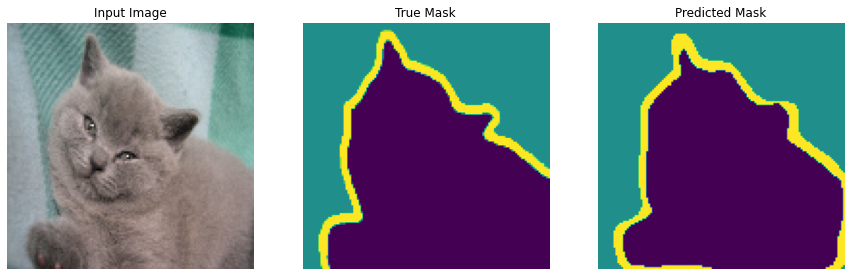

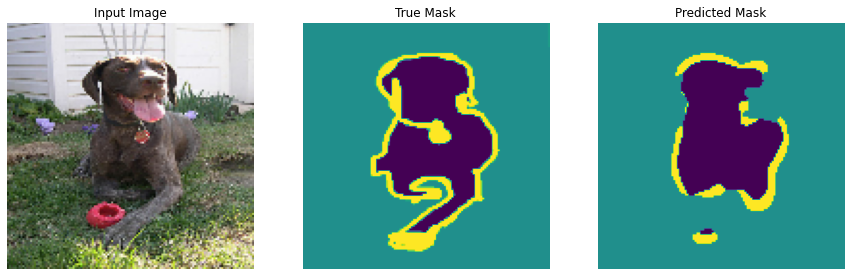

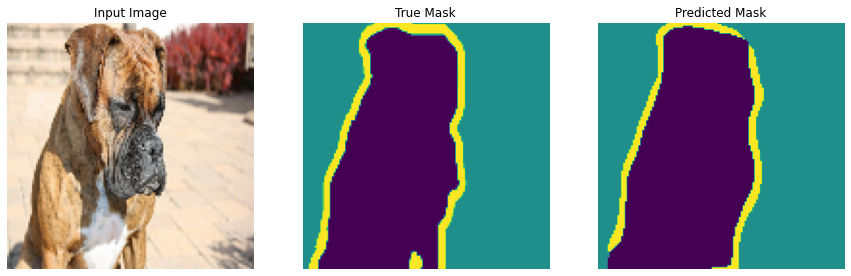

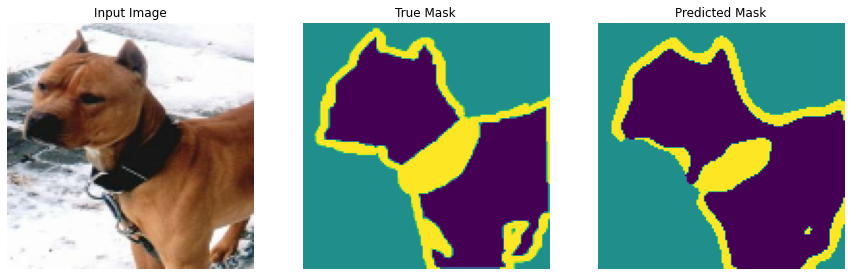

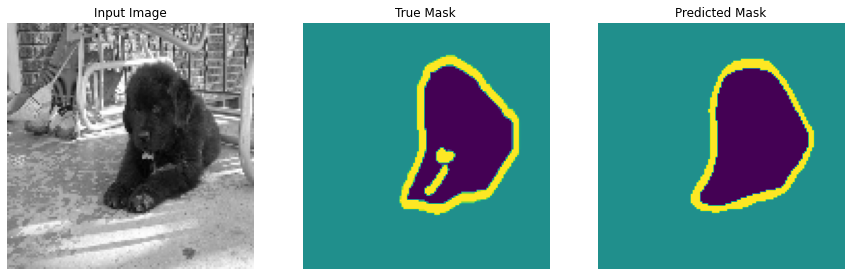

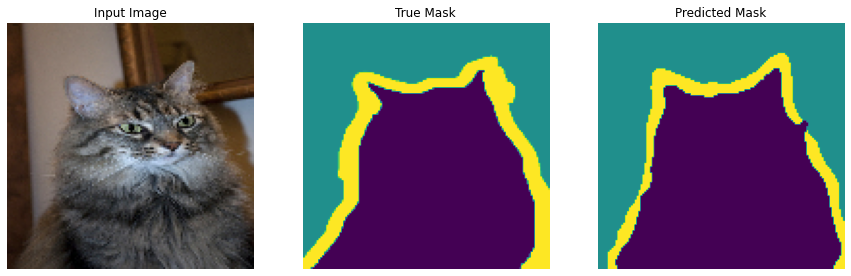

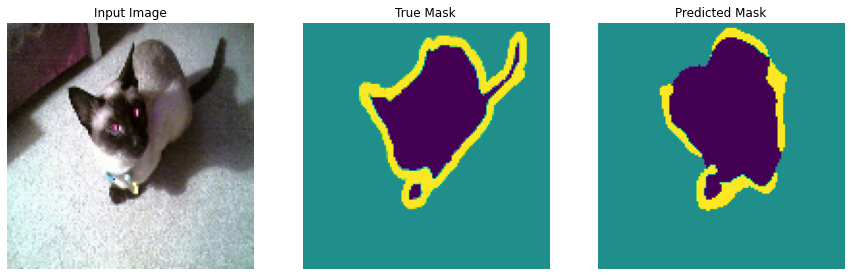

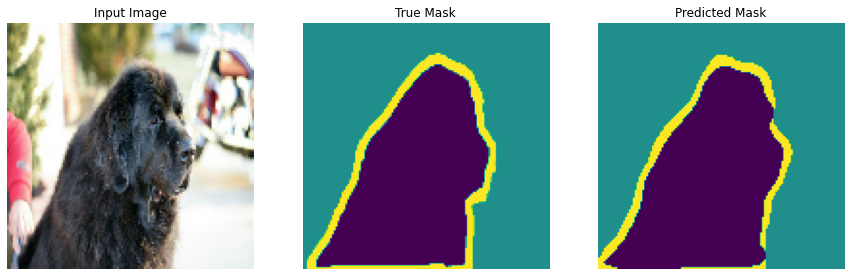

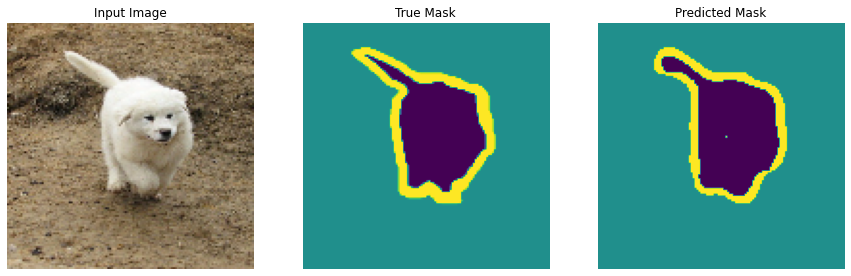

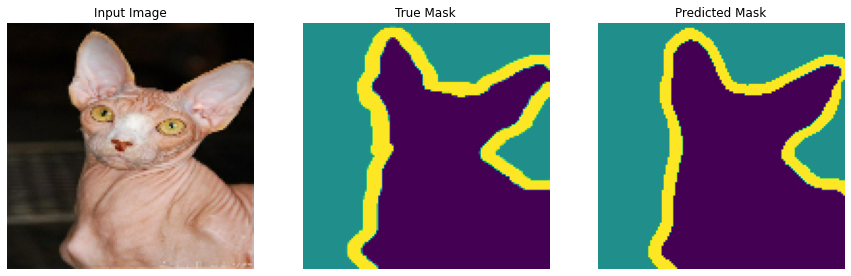

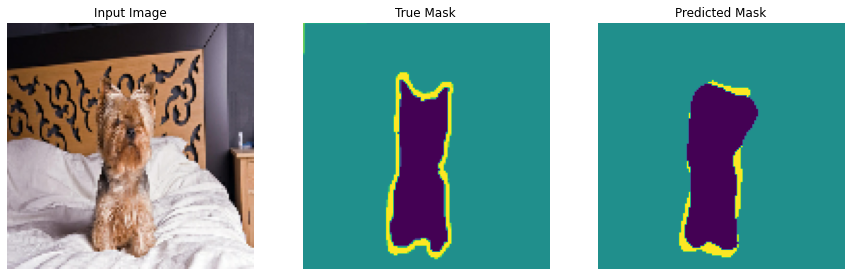

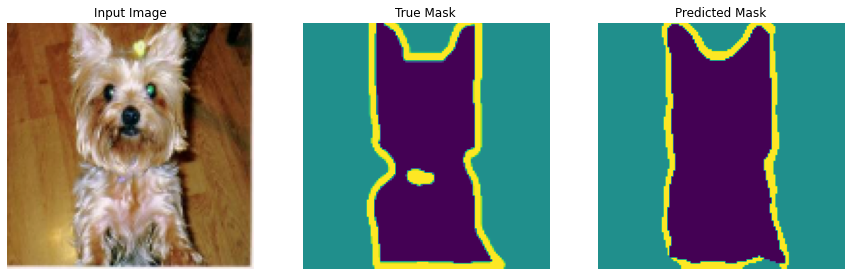

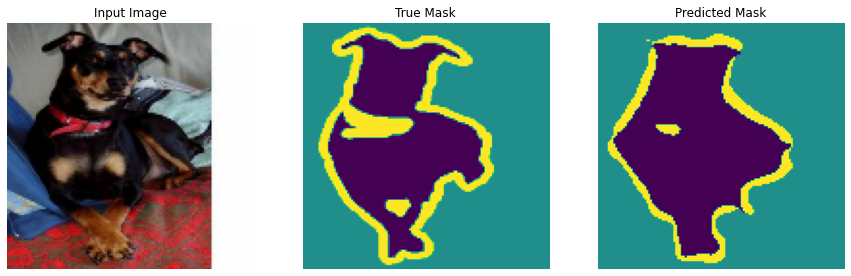

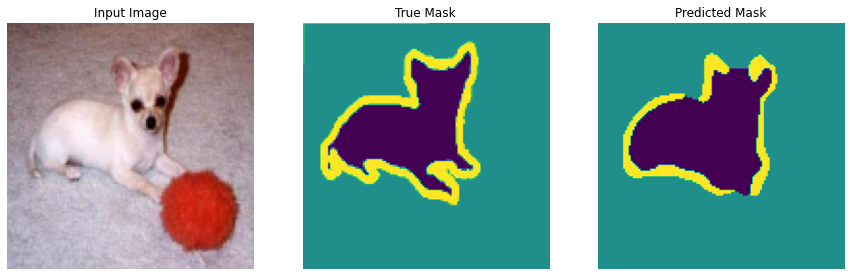

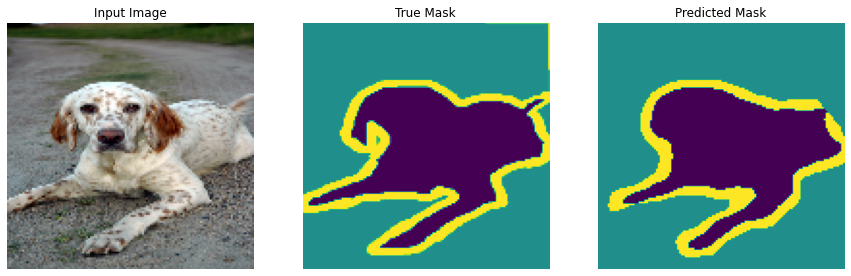

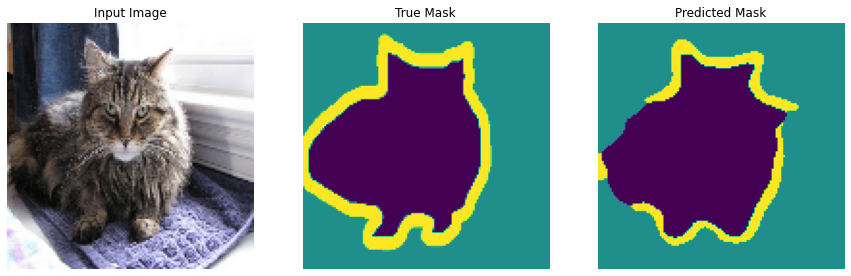

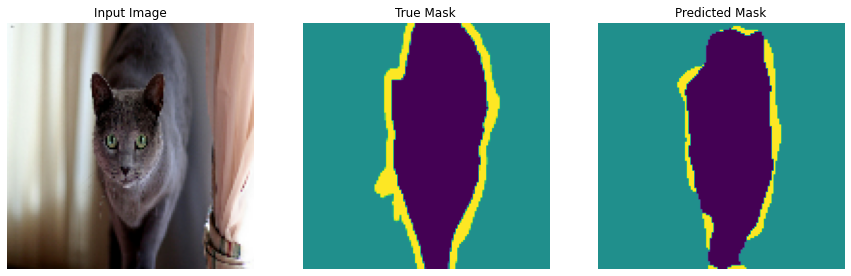

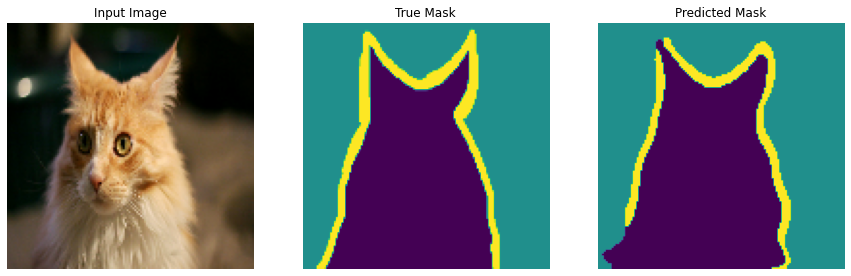

In [ ]:
show_predictions(model, train_dataset, 20)